In [62]:
import numpy as np
import os
folder_path = '/Users/mazenelsaadany/Desktop/UVM/Courses/Spring2025/Machine_Learning/Project/Dyna'  # Replace with your folder pat
# folder_path = r"D:\work\Dyna_test"
# Code for the collab 
########################################
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = '/content/drive/MyDrive/Colab Notebooks' 
####################################################
# Loop through all files in the folder
for filename in os.listdir(folder_path):
  if filename.endswith('.npy'):
    file_path = os.path.join(folder_path, filename)
    try:
      data = np.load(file_path)
      print(f"Found data in {filename}:")
      # print(data)  # Or process the data as needed
    except Exception as e:
      print(f"Error loading {filename}: {e}")
# Load the data collected
TIME = np.load(os.path.join(folder_path, 'TIME.npy'))
U = np.load(os.path.join(folder_path, 'U_data.npy'))
print(U[0,:])
Y = np.load(os.path.join(folder_path, 'Y_matrix.npy'))
delta = Y[:,0:6]*np.pi/180  # Convert degrees to radians
omega = Y[:,6:12]
theta = Y[:,12:12+23]*np.pi/180  # Convert degrees to radians
V = Y[:,12+23:12+23+23]

Y_new = np.hstack((delta, omega, theta, V))
X = np.hstack(( TIME, U))


X_norm = (X - np.mean(X,axis=0))/np.std(X,axis=0)
mu_x = np.mean(X,axis=0)[1:]
sigma_x = np.std(X,axis=0)[1:]
# cast mean and std to float32
mu_x = mu_x.astype(np.float32)
sigma_x = sigma_x.astype(np.float32)
X_norm[:,0]=X[:,0]

Y_norm = (Y_new - np.mean(Y_new,axis=0))/np.std(Y_new,axis=0)
mu_y = np.mean(Y_new,axis=0)
sigma_y = np.std(Y_new,axis=0)
# cast mean and std to float32
mu_y = mu_y.astype(np.float32)
sigma_y = sigma_y.astype(np.float32)

#  Increase the weight of the first 100 samples in each sequence

Found data in delta.npy:
Found data in Y_matrix.npy:
Found data in v.npy:
Found data in X_DATA.npy:
Found data in X0.npy:
Found data in TIME.npy:
Found data in omega.npy:
Found data in U_data.npy:
Found data in theta.npy:
[ 112.28518545  638.85519599  425.90351815  310.35293964 1264.15612287
  100.50809522  207.49006294  208.58662549  -56.51201767 -510.17009019
 -396.79890906 -160.53156224 -776.84976018  -50.50938217  -80.72274487
  -81.57822972]


In [63]:
# ============================================================================
# Physics-Informed Neural Network with a dynamic regularisation weight λ(t)
# ============================================================================
import numpy as np, tensorflow as tf, time
from sklearn.model_selection import train_test_split
from tensorflow.keras.saving import register_keras_serializable

# ──────────────────────────────────────────────────────────────────────────────
# Helper: schedule λ(t) during training
# ──────────────────────────────────────────────────────────────────────────────
class LambdaScheduler(tf.keras.callbacks.Callback):
    """
    Linearly ramps λ from λ_min → λ_max over the course of training.
    (Feel free to swap the formula in on_epoch_begin for an exponential,
     cosine, or piece-wise schedule if you prefer.)
    """
    def __init__(self, lam_var: tf.Variable,
                 lam_min: float,
                 lam_max: float,
                 epochs: int):
        super().__init__()
        self.lam_var  = lam_var          # the tf.Variable created inside the trainer
        self.lam_min  = float(lam_min)
        self.lam_max  = float(lam_max)
        self.epochs   = int(epochs)

    def on_epoch_begin(self, epoch, logs=None):
        prog   = epoch / max(1, self.epochs-1)      # 0 → 1
        new_lam = self.lam_min + (prog-0.4) * (self.lam_max - self.lam_min)
        new_lam = max(0.0, new_lam)                 # avoid negative λ
        new_lam = min(self.lam_max, new_lam)         # avoid exceeding λ_max
        self.lam_var.assign(new_lam)                # ← update in-graph variable
        tf.print("λ =", self.lam_var, " (epoch", epoch, ")")

# ──────────────────────────────────────────────────────────────────────────────
# Main trainer
# ──────────────────────────────────────────────────────────────────────────────
class PhysicsNNTrainer:
    # ------------------------------------------------------------------ init
    def __init__(self, X_norm, Y_norm, mu_y, sigma_y,
                 batch_size=64, test_size=0.20,
                 hidden_units=64, n_layers=1,
                 activation='relu',
                 lambda_reg=1,):          # ← λ_max (final value)

        # (1) keep normalisation tensors
        self.mu_y    = tf.constant(mu_y,    tf.float32)
        self.sigma_y = tf.constant(sigma_y, tf.float32)

        # λ will be **mutated** by the callback, so make it a tf.Variable
        self.lambda_r = tf.Variable(0.0, dtype=tf.float32, trainable=False,
                                    name="lambda_reg")   # initialise small

        # (2) deterministic split
        X_tr, X_te, Y_tr, Y_te = train_test_split(
            X_norm, Y_norm, test_size=test_size, shuffle=False)
        
        sample_weights = np.ones(X_tr.shape[0])
        print("size of sample weights: ", sample_weights.shape)  # Start with equal weights
        for i in range(0, X_tr.shape[0], 802):
            sample_weights[i:i+100] = 10  # 
            # sample_weights[i+700:i+802] = 10  # 


        # (3) identical Dataset pipeline
        def make_ds(x, y,weights= None):
            if weights is None:
                return (tf.data.Dataset
                        .from_tensor_slices((x.astype('f'), y.astype('f')))  # (x, y)
                        .shuffle(10_000)
                        .batch(batch_size)
                        .prefetch(tf.data.AUTOTUNE))
            else:
                return (tf.data.Dataset
                        .from_tensor_slices((x.astype('f'), (y.astype('f'), weights.astype('f')))) # (x, (y, w))
                        .shuffle(10_000)
                        .batch(batch_size)
                        .prefetch(tf.data.AUTOTUNE))
        self.ds_train, self.ds_test = make_ds(X_tr, Y_tr,sample_weights), make_ds(X_te, Y_te)

        # (4) build the model
        self.model = self._build_model(hidden_units, n_layers, activation)

        # remember λ_max so the callback knows where to ramp to
        self.lambda_max = float(lambda_reg)

    # ========================================================== swing eqn ==
    @staticmethod
    def _physics(y_pred):
        Gen_bus = [0, 1, 11, 12, 21, 22]
        V_idx   = [12 + 23 + i for i in Gen_bus]
        th_idx  = [12 + i      for i in Gen_bus]

        H   = tf.constant([36, 36, 25, 36.25, 30, 3.9],  tf.float32)
        D   = tf.constant([90, 90, 100, 72.5, 0, 0],     tf.float32)
        E   = tf.constant([1.07488163, 1.07488163, 1.18653694,
                           1.06655853, 1.07838708, 1.2603447], tf.float32)
        xdp = tf.constant([0.03333, 0.03333, 0.025, 0.03586, 0.035, 0.269], tf.float32)
        Pm  = tf.constant([7.5, 7.5, 8, 6, 2.5863, 1], tf.float32)

        Vg    = tf.gather(y_pred, V_idx, axis=1)
        th_g  = tf.gather(y_pred, th_idx, axis=1)
        delta = y_pred[:, :6]
        omega = y_pred[:, 6:12]

        Pe        = (Vg * E) / xdp * tf.sin(delta - th_g)
        domega_dt = (1 / (2 * H)) * (Pm - Pe - D * omega)
        ddelta_dt = (2 * np.pi * 60.0) * omega
        return tf.concat([ddelta_dt, domega_dt], axis=1)     #  (batch, 12)

    # ---------------------------------------------------------------- model
    def _build_model(self, hidden_units, n_layers, activation):

        mu_y, sigma_y, lam_var = self.mu_y, self.sigma_y, self.lambda_r
        physics_fn = self._physics
        act        = tf.keras.activations.get(activation)
        
        @register_keras_serializable(package='PhysicsNN')
        class PhysNet(tf.keras.Model):
            def __init__(self,**kwargs):
                super().__init__(**kwargs)
                self.hidden = []
                for _ in range(n_layers):
                    self.hidden.append(tf.keras.layers.Dense(hidden_units, activation=act))
                    self.hidden.append(tf.keras.layers.Dropout(0.2))  # Add dropout with 20% rate
                self.out = tf.keras.layers.Dense(58)

            # ---------- forward ------------------------------------------
            def call(self, x):
                for layer in self.hidden:
                    x = layer(x)
                return self.out(x)

            # ---------- training step ------------------------------------
            @tf.function
            def train_step(self, data):
                x, (y, w) = data                    # x: (batch, 17)  y: (batch, 58)

                with tf.GradientTape() as tape:
                    tape.watch(x)
                    y_pred = self(x, training=True)

                    # ----- NN loss (on normalised targets) ---------------
                    base_loss = tf.reduce_mean(tf.square(y - y_pred) * tf.expand_dims(w, axis=-1))  # Apply weights here

                    # ----- Physics loss ----------------------------------
                    y_pred_act = y_pred @ tf.linalg.diag(sigma_y) + mu_y

                    # dŷ/dt via autodiff on NN
                    GRADS = []
                    for i in range(12):
                        g = tf.gradients(y_pred[:, i], x)[0][:, 0]
                        GRADS.append(g)
                    grad_nn  = tf.reshape(GRADS, (tf.shape(x)[0], 12))

                    # dŷ/dt from swing equations
                    grad_phy = physics_fn(y_pred_act) @ tf.linalg.diag(1/sigma_y[:12])

                    phy_loss = tf.reduce_mean(tf.square(grad_phy - grad_nn))

                    # total weighted loss  (λ is read **from the Variable**)
                    total_loss = base_loss + lam_var * phy_loss

                # apply gradients
                grads = tape.gradient(total_loss, self.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

                return {"loss":       total_loss,
                        "base_loss":  base_loss,
                        "phy_loss":   phy_loss,
                        "lambda":     lam_var}

        
        # --- Add get_config for saving ---
            # Even though it's nested, Keras needs this when saving the model object
            def get_config(self):
                config = super().get_config()
                # Add any specific config needed to reconstruct THIS PhysNet instance
                # In this nested case, hidden_units, n_layers, activation are
                # captured from the outer scope, so they aren't instance attributes.
                # This might still cause issues with loading if not refactored.
                # A minimal config might be sufficient if layers are saved.
                # config.update({
                #     # Add layer configs if necessary, but Keras usually handles this
                # })
                return config
        
        
        return PhysNet()

# ──────────────────────────────────────────────────────────────────────────────
# Usage
# ──────────────────────────────────────────────────────────────────────────────
#   X_norm, Y_norm, mu_y, sigma_y  : your dataset / normalisation stats
# ----------------------------------------------------------------------------



In [66]:

trainer = PhysicsNNTrainer(
    X_norm, Y_norm, mu_y, sigma_y,
    batch_size   = 1024,
    hidden_units = 256,
    n_layers     = 4,
    activation   = 'relu',
    lambda_reg   = 0.15)       # λ_max  (final value once schedule ramps up)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=False)

# compile as usual
trainer.model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule,clipnorm=0.5),
    loss=tf.keras.losses.MeanSquaredError())
    # loss=tf.keras.losses.MeanAbsoluteError(),
    # )

# callbacks ------------------------------------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True)
# add a ModelCheckpoint if you want to save the best model
model_file = "physics_nn_model.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)

lam_sched = LambdaScheduler(
    lam_var = trainer.lambda_r,   # the tf.Variable inside the trainer
    lam_min = 0.0,               # start essentially physics-free
    lam_max = trainer.lambda_max, # finish at the user-provided λ_max
    epochs  = 20)               # total planned epochs (see fit() below)


size of sample weights:  (641600,)


In [67]:

# train ---------------------------------------------------------------
history = trainer.model.fit(
    trainer.ds_train,
    validation_data = trainer.ds_test,
    epochs          = 20,
    callbacks       = [lam_sched, early_stop, checkpoint])

λ = 0  (epoch 0 )
Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - base_loss: 0.2360 - lambda: 0.0000e+00 - loss: 0.2360 - phy_loss: 2432.9587
Epoch 1: val_loss improved from inf to 0.16286, saving model to physics_nn_model.keras
627/627 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - base_loss: 0.2358 - lambda: 0.0000e+00 - loss: 0.2358 - phy_loss: 2430.2317 - val_loss: 0.1629
λ = 0  (epoch 1 )
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - base_loss: 0.1759 - lambda: 0.0000e+00 - loss: 0.1759 - phy_loss: 1015.9440
Epoch 2: val_loss improved from 0.16286 to 0.14805, saving model to physics_nn_model.keras
627/627 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - base_loss: 0.1757 - lambda: 0.0000e+00 - loss: 0.1757 - phy_loss: 1015.0688 - val_loss: 0.1481
λ = 0  (epoch 2 )
Epoch 3/20
626/627 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - base_loss: 0.1635 - lambda: 0.0000e+00 - loss: 0.1635 - phy_loss: 881.4807
Epoch 3: val_loss improved from 0.14805 to 0.14279, saving model to physics_nn_model.keras
627/6

In [53]:
#load the best model
import tensorflow as tf
tester = PhysicsNNTrainer(
    X_norm, Y_norm, mu_y, sigma_y,
    batch_size   = 1024,
    hidden_units = 256,
    n_layers     = 4,
    activation   = 'relu',
    lambda_reg   = 0.15)   
model_file = "physics_nn_model2.keras"
tester.model = tf.keras.models.load_model(model_file)

# evaluate the model
test_loss = tester.model.evaluate(tester.ds_test)
print(f"Test Loss: {test_loss}")
# evaluate the mse on test data
y_pred = tester.model.predict(tester.ds_test)
y_true = np.concatenate([y for _, y in tester.ds_test], axis=0)
print(f"y_pred shape: {y_pred.shape}, y_true shape: {y_true.shape}")
mse =np.mean(np.square(y_true - y_pred))
print(f"Mean Squared Error on Test Data: {mse}")

size of sample weights:  (641600,)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1233
Test Loss: 0.13475753366947174
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
y_pred shape: (160400, 58), y_true shape: (160400, 58)
Mean Squared Error on Test Data: 1.7921820878982544


<LossFunctionWrapper(<function mean_squared_error at 0x177e9fba0>, kwargs={})>

6
(802, 17)
(802, 58)
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


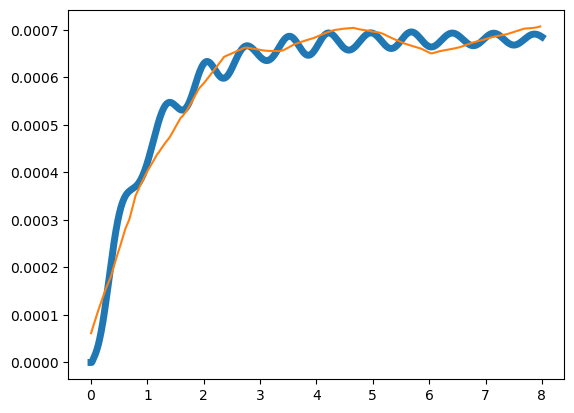

In [69]:
import matplotlib.pyplot as plt
 
case_num = 906
Ngen = 6
Nbus = 23
# delta --> var_plot = 1
# omega --> var_plot = 2
# theta --> var_plot = 3
#   V   --> var_plot = 4
var_plot = 2

gen_plot = 1
bus_plot = 1
 
 
idx = (var_plot==1)*(gen_plot-1) + (var_plot==2)*(gen_plot+Ngen-1) + (var_plot==3)*(bus_plot+2*Ngen-1) + (var_plot==4)*(bus_plot+2*Ngen+Nbus-1)
print(idx)
X_plot = X_norm[802*(case_num-1):802*case_num,:];
Y_plot = Y_norm[802*(case_num-1):802*case_num,:];
 
print(X_plot.shape)
print(Y_plot.shape)
 
time = TIME[:802]
Y_pred = tester.model.predict(X_plot)
# Y_pred = Y_pred*sigma_y+mu_y
y = Y_plot[:,idx]*sigma_y[idx] + mu_y[idx]  # Rescale the output
# y = Y_plot[:,idx]
plt.plot(time,y,linewidth=5)
plt.plot(time[0:799],(Y_pred[0:799,idx]*sigma_y[idx] + mu_y[idx]))
# plt.plot(time[0:100],np.mean(Y_plot,axis=0)[10]*np.ones(time.shape))
plt.show()
# Y_pred = np.zeros((0,57))